# CS-GY 9223-D: Deep Learning Homework 2
Due on Friday, 12th March 2019, 11:55 PM

This homework can be done in pairs.

Write down the UNIs (NetIDs) of your group (if applicable)

Member 1: Hupo Tang, ht1073

Member 2: Name, NetID

In [1]:
import os
import numpy as np
import glob
import tensorflow as tf
from keras.models import Sequential, Model

from keras.layers.core import Flatten, Dense, Dropout, Lambda, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

from keras.layers import Input
from keras.layers import Dense, Dropout, BatchNormalization, AveragePooling2D, concatenate, ZeroPadding2D
from keras.layers import add, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras import regularizers
from keras.optimizers import SGD, RMSprop, Adam
from keras.models import load_model

import cv2
# import matplotlib.pylab as plt
# %matplotlib inline

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [3]:
data_path = './'
TRAIN = './images_training_rev1/'
VALID = './images_validation_rev1'
TEST = './images_test_rev1/'
LABELS = './training_solutions_rev1.csv'

## Train and validation data split

In [ ]:
'''
Do not run twice ever!!!
'''

# g = glob.glob(data_path+'images_training_rev1/*.jpg')
# shuf = np.random.permutation(g)
# for i in range(2000):
#     os.rename(shuf[i], data_path + 'images_validation_rev1/' + shuf[i].split("/")[-1])

## Data preprocessing

### Use numpy array

In [ ]:
groundtruth_train=pd.read_csv('./training_solutions_rev1.csv') # train中每个图像的相关类别的概率分布, dataframe type

lst=os.listdir('./images_training_rev1/') # train中每个图像的filename，即图像id，构成的list
# lst.sort()
len(lst)
lst_v = os.listdir('./images_validation_rev1/')
len(lst_v)

In [ ]:
import cv2
from scipy.misc import imresize

train_imgs=[]
train_labels=[]
for img_name in lst:
    file_name='./images_training_rev1/'+img_name
    img = cv2.imread(file_name).T
    img = img[:,108:315,108:315] #crop 424x424 -> 207x207
    img = imresize(img,size=(69,69,3),interp="cubic")
    train_imgs.append(img)
    train_labels.append(groundtruth_train.query('GalaxyID == {}'.format(img_name.split('.')[0])).values[0,1:])
train_X = np.stack(train_imgs)
train_y=np.stack(train_labels)
np.save('X_train', train_X)
np.save('y_train', train_y)

val_imgs=[]
val_labels=[]
for img_name in lst_v:
    file_name='./images_validation_rev1/'+img_name
    img = cv2.imread(file_name).T
    img = img[:,108:315,108:315] #crop 424x424 -> 207x207
    img = imresize(img,size=(69,69,3),interp="cubic")
    val_imgs.append(img)
    val_labels.append(groundtruth_train.query('GalaxyID == {}'.format(img_name.split('.')[0])).values[0,1:])
val_X = np.stack(val_imgs)
val_y=np.stack(val_labels)
np.save('X_val', val_X)
np.save('y_val', val_y)

In [3]:
X_train, y_train = np.load('X_train.npy'), np.load('y_train.npy')
X_val, y_val = np.load('X_val.npy'), np.load('y_val.npy')
X_train.shape, y_train.shape
X_val.shape, y_val.shape

((59562, 69, 69, 3), (59562, 37))

((2016, 69, 69, 3), (2016, 37))

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [5]:
datagen.fit(X_train)

### Use generator

In [4]:
from random import shuffle
from scipy.misc import imresize
import csv

class data_loader:    
    """
    Creates a class for handling train/valid/test data paths,
    training labels and image IDs.
    Useful for switching between sample and full datasets.
    """
    def __init__(self, path):    
        self.path = path 
        self.train_path = TRAIN
        self.val_path = VALID
        self.test_path = TEST
        
        def get_paths(directory):
            return [f for f in os.listdir(directory)]
        
        self.training_images_paths = get_paths(self.train_path)
        self.validation_images_paths = get_paths(self.val_path)
        self.test_images_paths = get_paths(self.test_path)    
        
        def get_all_solutions():
        # Import solutions file and load into self.solutions
            all_solutions = {}
            # /'training_solutions_rev1.csv'
            with open(LABELS, 'r') as f:
                reader = csv.reader(f, delimiter=",")
                next(reader)
                for i, line in enumerate(reader):
                    all_solutions[line[0]] = [float(x) for x in line[1:]]
            return all_solutions
        
        self.all_solutions = get_all_solutions()

    def get_id(self,fname):
        return fname.replace(".jpg","").replace("data","")
        
    def find_label(self,val):
        return self.all_solutions[val]

In [5]:
def process_images(paths):
    """
    Import image at 'paths', decode, centre crop and prepare for batching. 
    This is images processing for VGG Model.
    """
    count = len(paths)
    arr = np.zeros(shape=(count,3,106,106))
    for c, path in enumerate(paths):
        img = cv2.imread(path).T
        img = img[:,106:106*3,106:106*3] #crop 424x424 -> 212x212
        img = imresize(img,size=(106,106,3),interp="cubic").T # downsample to half res
        arr[c] = img
    return arr

def BatchGenerator(getter):
    while 1:
        for f in getter.training_images_paths:
            X_train = process_images([getter.train_path + '/' + fname for fname in [f]])
            X_train = np.reshape(X_train, (1,106,106,3))
            id_ = getter.get_id(f)
            y_train = np.array(getter.find_label(id_))
            y_train = np.reshape(y_train,(1,37))
            yield (X_train, y_train)

def validGenerator(getter):
    while 1:
        for f in getter.validation_images_paths:
            X_val = process_images([getter.val_path + '/' + fname for fname in [f]])
            X_val = np.reshape(X_val, (1,106,106,3))
            id_ = getter.get_id(f)
            y_val = np.array(getter.find_label(id_))
            y_val = np.reshape(y_val, (1,37))
            yield (X_val, y_val)

### Data augmentation

In [6]:
# Expanded the original data by five times by rotating and flipping。

def rotate90(img):
    return np.rot90(img,axes=(1,2))

def rotate180(img):
    tmp = np.rot90(img,axes=(1,2))
    return np.rot90(tmp,axes=(1,2))

def rotate270(img):
    tmp = np.rot90(img,axes=(1,2))
    tmp = np.rot90(tmp,axes=(1,2))
    return np.rot90(tmp,axes=(1,2))

def flip_h(img):
    return np.flip(img, axis=1)

def flip_v(img):
    return np.flip(img, axis=2)

def process_withaug(paths,aug=0):
    count = len(paths)
    arr = np.zeros(shape=(count,3,106,106))
    for c, path in enumerate(paths):
        raw_img = cv2.imread(path).T
        if not aug:
            img=raw_img
        else:
            auger={1:rotate90,2:rotate180,3:rotate270,4:flip_h,5:flip_v}.get(aug)
            img=auger(raw_img)
        img = img[:,106:106*3,106:106*3]
        img = imresize(img,size=(106,106,3),interp="cubic").T
        arr[c] = img
    return arr

def BatchGenerator_withaug(getter):
    while 1:
        for f in getter.training_images_paths:
            for aug in {0,1,2,3,4,5}:
                X_train = process_withaug([getter.train_path + '/' + fname for fname in [f]], aug)
                X_train = np.reshape(X_train, (1,106,106,3))
                id_ = getter.get_id(f)
                y_train = np.array(getter.find_label(id_))
                y_train = np.reshape(y_train,(1,37))
                yield (X_train, y_train)


In [7]:
def process_images2(paths,aug=0):
    """
    Import image at 'paths', decode, centre crop and prepare for batching. 
    """
    count = len(paths)
    arr = np.zeros(shape=(count,3,69,69))
    for c, path in enumerate(paths):
        raw_img = cv2.imread(path).T
        if not aug:
            img=raw_img
        else:
            auger={1:rotate90,2:rotate180,3:rotate270,4:flip_h,5:flip_v}.get(aug)
            img=auger(raw_img)
        img = img[:,108:315,108:315] #crop 424x424 -> 207x207
        img = imresize(img,size=(69,69,3),interp="cubic").T # downsample to half res
        
#         img1 = np.sqrt(img[:1,:,:]*255)
#         img2 = np.sqrt(img[1:2,:,:])
#         img2 = np.append(img1, img2, axis=0)
#         img3 = np.sqrt(img[2:3,:,:])
#         img = np.append(img2, img3.reshape((1,69,69)), axis=0)
        
        arr[c] = img
    return arr

def BatchGenerator2(getter):
    while 1:
        for f in getter.training_images_paths:
            for aug in {0,1,2,3,4,5}:
                X_train = process_images2([getter.train_path + '/' + fname for fname in [f]], aug)
                X_train = np.reshape(X_train,(1,69,69,3))
                id_ = getter.get_id(f)
                y_train = np.array(getter.find_label(id_))
                y_train = np.reshape(y_train,(1,37))
                assert(X_train.shape==(1,69,69,3))
                yield (X_train, y_train)

def validGenerator2(getter):
    while 1:
        for f in getter.validation_images_paths:
            X_val = process_images2([getter.val_path + '/' + fname for fname in [f]])
            X_val = np.reshape(X_val, (1,69,69,3))
            id_ = getter.get_id(f)
            y_val = np.array(getter.find_label(id_))
            y_val = np.reshape(y_val, (1,37))
            yield (X_val, y_val)


In [8]:
def BatchGenerator3(getter,batch_size=32):
    batch_x,batch_y=[],[]
    while 1:
        img_id=0
        while(img_id<len(getter.training_images_paths)):
            f=getter.training_images_paths[img_id]
            aug=0
            while(aug<3):
                X_train = process_images2([getter.train_path + '/' + fname for fname in [f]], aug)
                X_train = np.reshape(X_train,(69,69,3))
                id_ = getter.get_id(f)
                y_train = np.array(getter.find_label(id_))
                y_train = np.reshape(y_train,(37))
                batch_x.append(X_train)
                batch_y.append(y_train)
                if len(batch_x)>=batch_size:
                    yield np.stack(batch_x),np.stack(batch_y)
                    batch_x,batch_y=[],[]
                aug+=1
            img_id+=1

def validGenerator3(getter,batch_size=32):
    batch_x,batch_y=[],[]
    while(True):
        img_id=0
        while(img_id<len(getter.validation_images_paths)):
            aug=0
            f=getter.validation_images_paths[img_id]
            X_val = process_images2([getter.val_path + '/' + fname for fname in [f]])
            X_val = np.reshape(X_val, (69,69,3))
            id_ = getter.get_id(f)
            y_val = np.array(getter.find_label(id_))
            y_val = np.reshape(y_val, (37))
            batch_x.append(X_val)
            batch_y.append(y_val)
            if len(batch_x)>=batch_size:
                yield np.stack(batch_x),np.stack(batch_y)
                batch_x,batch_y=[],[]
            aug+=1
            img_id+=1


In [6]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

In [10]:
fetcher = data_loader(data_path)

In [11]:
len(fetcher.validation_images_paths)

2016

## Build Model

### VGG

In [9]:
def ConvBlock(layers, model, filters):
    """
    Create a layered Conv/Pooling block
    """
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))  # zero padding of size 1
        model.add(Convolution2D(filters, 3, 3, activation='relu'))  # 3x3 filter size 
    model.add(MaxPooling2D((1,1), strides=(2,2)))

def FCBlock(model):
    """
    Fully connected block with ReLU and dropout
    """
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
def VGG_16():
    """
    Implement VGG16 architecture
    """
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=(106,106,3)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    
    model.add(Dense(37, activation = 'sigmoid'))
    return model

def VGG_16_2():
    """
    Implement VGG16 architecture
    """
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=(69,69,3)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    
    model.add(Dense(37, activation = 'sigmoid'))
    return model

In [27]:
# Compile 
optimizer = RMSprop(lr=1e-6)
model = VGG_16()
model2 = VGG_16_2()
model.compile(loss='mean_squared_error', optimizer=optimizer)
model2.compile(loss='mean_squared_error', optimizer=RMSprop(lr=1e-6))

### My CNN design 

In [7]:
def MyCNN():
    model = Sequential()
    #NHWC(,69,69,3)
    model.add(Lambda(lambda x: x, input_shape=(69,69,3)))
#     print(model.output_shape)    

    model.add(Convolution2D(8, 4, 4, activation='relu'))
    model.add(Convolution2D(16, 3, 3, activation='relu'))
#     model.add(Convolution2D(32, 6, 6, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
#     model.add(Convolution2D(64, 5, 5, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(128, 3, 3, activation='relu', W_regularizer=regularizers.l2(0.005)))
    model.add(Convolution2D(128, 3, 3, activation='relu', W_regularizer=regularizers.l2(0.01)))
#     model.add(Convolution2D(256, 3, 3, activation='relu', W_regularizer=regularizers.l2(0.01)))
    
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(2048, activation='elu'))
#     model.add(Dense(4096, activation='elu'))
    model.add(Dropout(0.2))
    model.add(Dense(2048, activation='elu'))
#     model.add(Dense(4096, activation='elu'))
    model.add(Dropout(0.2))
    model.add(Dense(37, activation='sigmoid'))
    return model

In [10]:
myModel = MyCNN()
myModel.compile(loss='mean_squared_error', optimizer=Adam(lr=5e-5))

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath='./tmp/myWeights.hdf5', verbose=1, save_best_only=True)

batch_size = 32
steps_to_take = int(len(fetcher.training_images_paths)/batch_size)
val_steps_to_take = int(len(fetcher.validation_images_paths)/batch_size)
                #typically be equal to the number of unique samples if your dataset
                #divided by the batch size.

history = LossHistory()

### ResNet

In [50]:
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, activation='relu')(x)
#     print(x.shape)
    x = BatchNormalization(axis=3)(x)
    return x

def identity_Block(inpt, nb_filter, kernel_size, strides=(1, 1), with_conv_shortcut=False):
    x = Conv2d_BN(inpt, nb_filter=nb_filter, kernel_size=kernel_size, strides=strides, padding='same')
    x = Conv2d_BN(x, nb_filter=nb_filter, kernel_size=kernel_size, padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt, nb_filter=nb_filter, strides=strides, kernel_size=kernel_size)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

def bottleneck_Block(inpt,nb_filters,strides=(1,1),with_conv_shortcut=False):
    k1,k2,k3=nb_filters
    x = Conv2d_BN(inpt, nb_filter=k1, kernel_size=1, strides=strides, padding='same')
    x = Conv2d_BN(x, nb_filter=k2, kernel_size=3, padding='same')
    x = Dropout(0.2)(x)
    x = Conv2d_BN(x, nb_filter=k3, kernel_size=1, padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt, nb_filter=k3, strides=strides, kernel_size=1)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

def resnet_50(width,height,channel,classes):
    inpt = Input(shape=(width, height, channel))
    x = ZeroPadding2D((2, 2))(inpt)
    x = Conv2d_BN(x, nb_filter=64, kernel_size=(6, 6), strides=(1, 1), padding='valid')
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    #conv2_x
    x = bottleneck_Block(x, nb_filters=[64,64,256],strides=(1,1),with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[64,64,256])

    #conv3_x
    x = bottleneck_Block(x, nb_filters=[128, 128, 512],strides=(2,2),with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[128, 128, 512])

    #conv4_x
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024],strides=(2,2),with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[256, 256, 1024])

    #conv5_x
    x = bottleneck_Block(x, nb_filters=[512, 512, 2048], strides=(2, 2), with_conv_shortcut=True)
    x = bottleneck_Block(x, nb_filters=[512, 512, 2048])

    x = AveragePooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    x = Dense(classes, activation='sigmoid')(x)

    model = Model(inputs=inpt, outputs=x)
    return model



In [51]:
resModel = resnet_50(69,69,3,37)
# model.summary()
resModel.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-5))

In [52]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath='./tmp/resWeights.hdf5', verbose=1, save_best_only=True)

batch_size = 32
steps_to_take = int(len(fetcher.training_images_paths)/batch_size)
val_steps_to_take = int(len(fetcher.validation_images_paths)/batch_size)
                #typically be equal to the number of unique samples if your dataset
                #divided by the batch size.

history = LossHistory()

In [53]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

## Train Model

In [8]:
input_shape = (69,69,3)
batch_size = 32
steps_to_take = int(X_train.shape[0]/batch_size)

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath='./tmp/MyWeights.hdf5', verbose=1, save_best_only=True)
history = LossHistory()

In [10]:
MyModel = MyCNN()
MyModel.compile(loss='mean_squared_error', optimizer=Adam(lr=5e-5))

In [11]:
MyHist2 = MyModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=30, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/30
 - 72s - loss: 0.3759 - val_loss: 0.0427

Epoch 00001: val_loss improved from inf to 0.04272, saving model to ./tmp/MyWeights.hdf5
Epoch 2/30
 - 72s - loss: 0.0297 - val_loss: 0.0218

Epoch 00002: val_loss improved from 0.04272 to 0.02182, saving model to ./tmp/MyWeights.hdf5
Epoch 3/30
 - 71s - loss: 0.0202 - val_loss: 0.0175

Epoch 00003: val_loss improved from 0.02182 to 0.01748, saving model to ./tmp/MyWeights.hdf5
Epoch 4/30
 - 72s - loss: 0.0170 - val_loss: 0.0155

Epoch 00004: val_loss improved from 0.01748 to 0.01551, saving model to ./tmp/MyWeights.hdf5
Epoch 5/30
 - 72s - loss: 0.0154 - val_loss: 0.0147

Epoch 00005: val_loss improved from 0.01551 to 0.01471, saving model to ./tmp/MyWeights.hdf5
Epoch 6/30
 - 72s - loss: 0.0144 - val_loss: 0.0134

Epoch 00006: val_loss improved from 0.01471 to 0.01338, saving model to ./tmp/MyWeights.hdf5
Epoch 7/30
 - 72s - loss: 0.0137 - val_loss: 0.0131

Epoch 00007: val_loss improved from 0.01338 to 0.01307, saving model to ./t

In [ ]:
MyHist2 = MyModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=30, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/30
 - 73s - loss: 0.0109 - val_loss: 0.0104

Epoch 00001: val_loss improved from 0.01048 to 0.01042, saving model to ./tmp/MyWeights.hdf5
Epoch 2/30
 - 72s - loss: 0.0108 - val_loss: 0.0105

Epoch 00002: val_loss did not improve from 0.01042
Epoch 3/30
 - 72s - loss: 0.0108 - val_loss: 0.0110

Epoch 00003: val_loss did not improve from 0.01042
Epoch 4/30
 - 73s - loss: 0.0108 - val_loss: 0.0105

Epoch 00004: val_loss did not improve from 0.01042
Epoch 5/30
 - 72s - loss: 0.0107 - val_loss: 0.0112

Epoch 00005: val_loss did not improve from 0.01042
Epoch 6/30
 - 72s - loss: 0.0107 - val_loss: 0.0106

Epoch 00006: val_loss did not improve from 0.01042
Epoch 7/30
 - 72s - loss: 0.0107 - val_loss: 0.0107

Epoch 00007: val_loss did not improve from 0.01042
Epoch 8/30
 - 71s - loss: 0.0106 - val_loss: 0.0106

Epoch 00008: val_loss did not improve from 0.01042
Epoch 9/30
 - 72s - loss: 0.0106 - val_loss: 0.0102

Epoch 00009: val_loss improved from 0.01042 to 0.01019, saving model to .

In [ ]:
plt.plot(MyHist2.epoch,MyHist2.history['loss'],label='Test')
plt.plot(MyHist2.epoch,MyHist2.history['val_loss'],label='Validation',linestyle='--')

In [ ]:
MyHist2 = MyModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=30, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

In [23]:
MyModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=30, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/30
 - 71s - loss: 0.8333 - val_loss: 0.4707

Epoch 00001: val_loss improved from inf to 0.47073, saving model to ./tmp/MyWeights.hdf5
Epoch 2/30
 - 71s - loss: 0.2885 - val_loss: 0.1618

Epoch 00002: val_loss improved from 0.47073 to 0.16181, saving model to ./tmp/MyWeights.hdf5
Epoch 3/30
 - 70s - loss: 0.1069 - val_loss: 0.0709

Epoch 00003: val_loss improved from 0.16181 to 0.07088, saving model to ./tmp/MyWeights.hdf5
Epoch 4/30
 - 71s - loss: 0.0566 - val_loss: 0.0458

Epoch 00004: val_loss improved from 0.07088 to 0.04580, saving model to ./tmp/MyWeights.hdf5
Epoch 5/30
 - 70s - loss: 0.0409 - val_loss: 0.0357

Epoch 00005: val_loss improved from 0.04580 to 0.03570, saving model to ./tmp/MyWeights.hdf5
Epoch 6/30
 - 72s - loss: 0.0329 - val_loss: 0.0297

Epoch 00006: val_loss improved from 0.03570 to 0.02974, saving model to ./tmp/MyWeights.hdf5
Epoch 7/30
 - 71s - loss: 0.0279 - val_loss: 0.0254

Epoch 00007: val_loss improved from 0.02974 to 0.02539, saving model to ./t

In [24]:
MyHist = MyModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=30, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/30
 - 72s - loss: 0.0110 - val_loss: 0.0109

Epoch 00001: val_loss did not improve from 0.01084
Epoch 2/30
 - 71s - loss: 0.0109 - val_loss: 0.0108

Epoch 00002: val_loss did not improve from 0.01084
Epoch 3/30
 - 71s - loss: 0.0108 - val_loss: 0.0107

Epoch 00003: val_loss improved from 0.01084 to 0.01066, saving model to ./tmp/MyWeights.hdf5
Epoch 4/30
 - 71s - loss: 0.0107 - val_loss: 0.0110

Epoch 00004: val_loss did not improve from 0.01066
Epoch 5/30
 - 71s - loss: 0.0107 - val_loss: 0.0106

Epoch 00005: val_loss improved from 0.01066 to 0.01058, saving model to ./tmp/MyWeights.hdf5
Epoch 6/30
 - 70s - loss: 0.0106 - val_loss: 0.0105

Epoch 00006: val_loss improved from 0.01058 to 0.01051, saving model to ./tmp/MyWeights.hdf5
Epoch 7/30
 - 71s - loss: 0.0106 - val_loss: 0.0108

Epoch 00007: val_loss did not improve from 0.01051
Epoch 8/30
 - 70s - loss: 0.0105 - val_loss: 0.0106

Epoch 00008: val_loss did not improve from 0.01051
Epoch 9/30
 - 70s - loss: 0.0105 - val_los

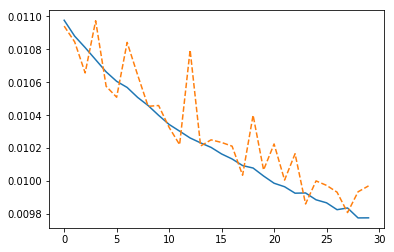

In [26]:
import matplotlib.pylab as plt
%matplotlib inline

plt.plot(MyHist.epoch,MyHist.history['loss'],label='Test')
plt.plot(MyHist.epoch,MyHist.history['val_loss'],label='Validation',linestyle='--')

In [ ]:
MyHist = MyModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=30, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/30
 - 71s - loss: 0.0097 - val_loss: 0.0098

Epoch 00001: val_loss improved from 0.00981 to 0.00980, saving model to ./tmp/MyWeights.hdf5
Epoch 2/30
 - 71s - loss: 0.0097 - val_loss: 0.0100

Epoch 00002: val_loss did not improve from 0.00980
Epoch 3/30
 - 71s - loss: 0.0097 - val_loss: 0.0100

Epoch 00003: val_loss did not improve from 0.00980
Epoch 4/30
 - 70s - loss: 0.0097 - val_loss: 0.0099

Epoch 00004: val_loss did not improve from 0.00980
Epoch 5/30
 - 70s - loss: 0.0097 - val_loss: 0.0097

Epoch 00005: val_loss improved from 0.00980 to 0.00967, saving model to ./tmp/MyWeights.hdf5
Epoch 6/30
 - 71s - loss: 0.0096 - val_loss: 0.0098

Epoch 00006: val_loss did not improve from 0.00967
Epoch 7/30
 - 70s - loss: 0.0096 - val_loss: 0.0098

Epoch 00007: val_loss did not improve from 0.00967
Epoch 8/30
 - 71s - loss: 0.0096 - val_loss: 0.0098

Epoch 00008: val_loss did not improve from 0.00967
Epoch 9/30
 - 70s - loss: 0.0096 - val_loss: 0.0099

Epoch 00009: val_loss did not i

In [29]:
MyHist = MyModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=15, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/15
 - 70s - loss: 0.0093 - val_loss: 0.0096

Epoch 00001: val_loss did not improve from 0.00947
Epoch 2/15
 - 71s - loss: 0.0093 - val_loss: 0.0096

Epoch 00002: val_loss did not improve from 0.00947
Epoch 3/15
 - 70s - loss: 0.0093 - val_loss: 0.0095

Epoch 00003: val_loss did not improve from 0.00947
Epoch 4/15
 - 70s - loss: 0.0092 - val_loss: 0.0095

Epoch 00004: val_loss did not improve from 0.00947
Epoch 5/15
 - 70s - loss: 0.0093 - val_loss: 0.0094

Epoch 00005: val_loss improved from 0.00947 to 0.00942, saving model to ./tmp/MyWeights.hdf5
Epoch 6/15
 - 70s - loss: 0.0092 - val_loss: 0.0097

Epoch 00006: val_loss did not improve from 0.00942
Epoch 7/15
 - 71s - loss: 0.0092 - val_loss: 0.0095

Epoch 00007: val_loss did not improve from 0.00942
Epoch 8/15
 - 70s - loss: 0.0092 - val_loss: 0.0094

Epoch 00008: val_loss did not improve from 0.00942
Epoch 9/15
 - 70s - loss: 0.0092 - val_loss: 0.0094

Epoch 00009: val_loss improved from 0.00942 to 0.00941, saving model to .

In [35]:
MyHist = MyModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=15, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/15
 - 72s - loss: 0.0091 - val_loss: 0.0094

Epoch 00001: val_loss did not improve from 0.00934
Epoch 2/15
 - 71s - loss: 0.0091 - val_loss: 0.0093

Epoch 00002: val_loss improved from 0.00934 to 0.00933, saving model to ./tmp/MyWeights.hdf5
Epoch 3/15
 - 70s - loss: 0.0091 - val_loss: 0.0095

Epoch 00003: val_loss did not improve from 0.00933
Epoch 4/15
 - 70s - loss: 0.0091 - val_loss: 0.0095

Epoch 00004: val_loss did not improve from 0.00933
Epoch 5/15
 - 70s - loss: 0.0091 - val_loss: 0.0095

Epoch 00005: val_loss did not improve from 0.00933
Epoch 6/15
 - 70s - loss: 0.0091 - val_loss: 0.0094

Epoch 00006: val_loss did not improve from 0.00933
Epoch 7/15
 - 70s - loss: 0.0090 - val_loss: 0.0095

Epoch 00007: val_loss did not improve from 0.00933
Epoch 8/15
 - 71s - loss: 0.0090 - val_loss: 0.0094

Epoch 00008: val_loss did not improve from 0.00933
Epoch 9/15
 - 71s - loss: 0.0091 - val_loss: 0.0094

Epoch 00009: val_loss did not improve from 0.00933
Epoch 10/15
 - 71s - l

In [37]:
MyHist = MyModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=15, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/15
 - 71s - loss: 0.0090 - val_loss: 0.0095

Epoch 00001: val_loss did not improve from 0.00928
Epoch 2/15
 - 71s - loss: 0.0090 - val_loss: 0.0095

Epoch 00002: val_loss did not improve from 0.00928
Epoch 3/15
 - 71s - loss: 0.0090 - val_loss: 0.0093

Epoch 00003: val_loss did not improve from 0.00928
Epoch 4/15
 - 71s - loss: 0.0089 - val_loss: 0.0094

Epoch 00004: val_loss did not improve from 0.00928
Epoch 5/15
 - 70s - loss: 0.0089 - val_loss: 0.0092

Epoch 00005: val_loss improved from 0.00928 to 0.00924, saving model to ./tmp/MyWeights.hdf5
Epoch 6/15
 - 71s - loss: 0.0089 - val_loss: 0.0092

Epoch 00006: val_loss did not improve from 0.00924
Epoch 7/15
 - 71s - loss: 0.0089 - val_loss: 0.0096

Epoch 00007: val_loss did not improve from 0.00924
Epoch 8/15
 - 71s - loss: 0.0089 - val_loss: 0.0092

Epoch 00008: val_loss improved from 0.00924 to 0.00916, saving model to ./tmp/MyWeights.hdf5
Epoch 9/15
 - 71s - loss: 0.0089 - val_loss: 0.0091

Epoch 00009: val_loss improved 

In [39]:
MyHist = MyModel.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=steps_to_take,
                        validation_data=(X_val, y_val),
                        epochs=15, verbose=2, max_q_size=100,
                        callbacks=[history,checkpointer,early_stopping])

Epoch 1/15
 - 71s - loss: 0.0088 - val_loss: 0.0094

Epoch 00001: val_loss did not improve from 0.00910
Epoch 2/15
 - 71s - loss: 0.0088 - val_loss: 0.0092

Epoch 00002: val_loss did not improve from 0.00910
Epoch 3/15
 - 71s - loss: 0.0088 - val_loss: 0.0091

Epoch 00003: val_loss did not improve from 0.00910
Epoch 4/15
 - 70s - loss: 0.0088 - val_loss: 0.0093

Epoch 00004: val_loss did not improve from 0.00910
Epoch 5/15
 - 71s - loss: 0.0088 - val_loss: 0.0093

Epoch 00005: val_loss did not improve from 0.00910
Epoch 6/15
 - 70s - loss: 0.0088 - val_loss: 0.0093

Epoch 00006: val_loss did not improve from 0.00910
Epoch 7/15
 - 71s - loss: 0.0088 - val_loss: 0.0093

Epoch 00007: val_loss did not improve from 0.00910
Epoch 8/15
 - 70s - loss: 0.0088 - val_loss: 0.0092

Epoch 00008: val_loss did not improve from 0.00910
Epoch 9/15
 - 71s - loss: 0.0088 - val_loss: 0.0092

Epoch 00009: val_loss did not improve from 0.00910
Epoch 10/15
 - 71s - loss: 0.0088 - val_loss: 0.0093

Epoch 0001

In [ ]:
myhist1 = myModel.fit_generator(BatchGenerator3(fetcher),
                    samples_per_epoch=steps_to_take*3,
                    nb_epoch=20,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator3(fetcher),
                    validation_steps=val_steps_to_take
                    )

In [ ]:
# ResNet

reshist = resModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                    )

Epoch 1/50
 - 586s - loss: 0.0356 - val_loss: 0.1444

Epoch 00001: val_loss improved from inf to 0.14443, saving model to ./tmp/resWeights.hdf5
Epoch 2/50
 - 582s - loss: 0.0301 - val_loss: 0.1251

Epoch 00002: val_loss improved from 0.14443 to 0.12510, saving model to ./tmp/resWeights.hdf5
Epoch 3/50
 - 586s - loss: 0.0280 - val_loss: 0.1091

Epoch 00003: val_loss improved from 0.12510 to 0.10910, saving model to ./tmp/resWeights.hdf5
Epoch 4/50
 - 579s - loss: 0.0267 - val_loss: 0.0863

Epoch 00004: val_loss improved from 0.10910 to 0.08635, saving model to ./tmp/resWeights.hdf5
Epoch 5/50
 - 583s - loss: 0.0259 - val_loss: 0.0696

Epoch 00005: val_loss improved from 0.08635 to 0.06956, saving model to ./tmp/resWeights.hdf5
Epoch 6/50
 - 587s - loss: 0.0253 - val_loss: 0.0787

Epoch 00006: val_loss did not improve from 0.06956
Epoch 7/50
 - 589s - loss: 0.0253 - val_loss: 0.0580

Epoch 00007: val_loss improved from 0.06956 to 0.05798, saving model to ./tmp/resWeights.hdf5
Epoch 8/50


In [ ]:
reshist = resModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                    )

In [ ]:
# VGG16 with no augmentation

hist = model.fit_generator(BatchGenerator(fetcher),
                    samples_per_epoch=steps_to_take, 
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                   )
# 0.021

In [ ]:
# VGG16 with augmentation

hist_aug = model.fit_generator(BatchGenerator_withaug(fetcher),
                    samples_per_epoch=steps_to_take*3, 
                    nb_epoch=25,
                    verbose=2,
                    callbacks=[hist,checkpointer,early_stopping],
                   )
# 0.017

In [ ]:
#Aug with larger epochs

hist_aug2 = model.fit_generator(BatchGenerator_withaug(fetcher),
                    samples_per_epoch=steps_to_take*3, 
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[hist,checkpointer,early_stopping],
                   )
# 0.015

In [141]:
# VGG with data augmentation

hist_vaug = model.fit_generator(BatchGenerator_withaug(fetcher),
                    samples_per_epoch=steps_to_take,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[hist_v2,checkpointer,early_stopping],
                    validation_data=validGenerator(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 54s - loss: 0.0161 - val_loss: 0.0176

Epoch 00001: val_loss did not improve from 0.01435
Epoch 2/50
 - 54s - loss: 0.0159 - val_loss: 0.0140

Epoch 00002: val_loss improved from 0.01435 to 0.01405, saving model to ./tmp/weights.hdf5
Epoch 3/50
 - 54s - loss: 0.0154 - val_loss: 0.0155

Epoch 00003: val_loss did not improve from 0.01405
Epoch 4/50
 - 54s - loss: 0.0154 - val_loss: 0.0140

Epoch 00004: val_loss improved from 0.01405 to 0.01400, saving model to ./tmp/weights.hdf5
Epoch 5/50
 - 54s - loss: 0.0155 - val_loss: 0.0156

Epoch 00005: val_loss did not improve from 0.01400
Epoch 6/50
 - 54s - loss: 0.0158 - val_loss: 0.0159

Epoch 00006: val_loss did not improve from 0.01400
Epoch 7/50
 - 54s - loss: 0.0160 - val_loss: 0.0145

Epoch 00007: val_loss did not improve from 0.01400
Epoch 8/50
 - 54s - loss: 0.0157 - val_loss: 0.0149

Epoch 00008: val_loss did not improve from 0.01400
Epoch 9/50
 - 54s - loss: 0.0155 - val_loss: 0.0164

Epoch 00009: val_loss did not impro

In [25]:
# VGG_2

hist2 = model2.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=30,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/30
 - 268s - loss: 0.0171 - val_loss: 0.0353

Epoch 00001: val_loss improved from inf to 0.03526, saving model to ./tmp/weights.hdf5
Epoch 2/30
 - 269s - loss: 0.0159 - val_loss: 0.0411

Epoch 00002: val_loss did not improve from 0.03526
Epoch 3/30
 - 268s - loss: 0.0150 - val_loss: 0.0181

Epoch 00003: val_loss improved from 0.03526 to 0.01809, saving model to ./tmp/weights.hdf5
Epoch 4/30
 - 268s - loss: 0.0144 - val_loss: 0.0215

Epoch 00004: val_loss did not improve from 0.01809
Epoch 5/30
 - 268s - loss: 0.0140 - val_loss: 0.0343

Epoch 00005: val_loss did not improve from 0.01809
Epoch 6/30
 - 269s - loss: 0.0136 - val_loss: 0.0204

Epoch 00006: val_loss did not improve from 0.01809
Epoch 7/30
 - 268s - loss: 0.0135 - val_loss: 0.0172

Epoch 00007: val_loss improved from 0.01809 to 0.01721, saving model to ./tmp/weights.hdf5
Epoch 8/30
 - 269s - loss: 0.0134 - val_loss: 0.0323

Epoch 00008: val_loss did not improve from 0.01721
Epoch 9/30
 - 268s - loss: 0.0127 - val_loss

In [28]:
# VGG_2 train more

hist = model.fit_generator(BatchGenerator_withaug(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=30,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/30
 - 324s - loss: 0.0340 - val_loss: 0.0286

Epoch 00001: val_loss did not improve from 0.01721
Epoch 2/30
 - 322s - loss: 0.0235 - val_loss: 0.0307

Epoch 00002: val_loss did not improve from 0.01721
Epoch 3/30
 - 322s - loss: 0.0201 - val_loss: 0.0235

Epoch 00003: val_loss did not improve from 0.01721
Epoch 4/30
 - 321s - loss: 0.0179 - val_loss: 0.0232

Epoch 00004: val_loss did not improve from 0.01721
Epoch 5/30
 - 322s - loss: 0.0172 - val_loss: 0.0367

Epoch 00005: val_loss did not improve from 0.01721
Epoch 6/30
 - 322s - loss: 0.0164 - val_loss: 0.0208

Epoch 00006: val_loss did not improve from 0.01721
Epoch 7/30
 - 322s - loss: 0.0160 - val_loss: 0.0192

Epoch 00007: val_loss did not improve from 0.01721
Epoch 8/30
 - 322s - loss: 0.0157 - val_loss: 0.0351

Epoch 00008: val_loss did not improve from 0.01721
Epoch 9/30
 - 322s - loss: 0.0150 - val_loss: 0.0244

Epoch 00009: val_loss did not improve from 0.01721
Epoch 10/30
 - 321s - loss: 0.0148 - val_loss: 0.0245



In [29]:
# VGG_2 train more

hist2 = model.fit_generator(BatchGenerator_withaug(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=70,
                    verbose=2,
                    callbacks=[hist,checkpointer,early_stopping],
                    validation_data=validGenerator(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/70
 - 321s - loss: 0.0117 - val_loss: 0.0419

Epoch 00001: val_loss did not improve from 0.01662
Epoch 2/70
 - 321s - loss: 0.0116 - val_loss: 0.0348

Epoch 00002: val_loss did not improve from 0.01662
Epoch 3/70
 - 321s - loss: 0.0110 - val_loss: 0.0196

Epoch 00003: val_loss did not improve from 0.01662
Epoch 4/70
 - 322s - loss: 0.0112 - val_loss: 0.0279

Epoch 00004: val_loss did not improve from 0.01662
Epoch 5/70
 - 322s - loss: 0.0113 - val_loss: 0.0271

Epoch 00005: val_loss did not improve from 0.01662
Epoch 6/70
 - 322s - loss: 0.0113 - val_loss: 0.0161

Epoch 00006: val_loss improved from 0.01662 to 0.01611, saving model to ./tmp/weights.hdf5
Epoch 7/70
 - 321s - loss: 0.0115 - val_loss: 0.0206

Epoch 00007: val_loss did not improve from 0.01611
Epoch 8/70
 - 322s - loss: 0.0113 - val_loss: 0.0222

Epoch 00008: val_loss did not improve from 0.01611
Epoch 9/70
 - 322s - loss: 0.0112 - val_loss: 0.0277

Epoch 00009: val_loss did not improve from 0.01611
Epoch 10/70
 - 

In [19]:
# my CNN

myhist = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 159s - loss: 0.0321 - val_loss: 0.0221

Epoch 00001: val_loss improved from 0.04341 to 0.02207, saving model to ./tmp/myWeights.hdf5
Epoch 2/50
 - 156s - loss: 0.0197 - val_loss: 0.0175

Epoch 00002: val_loss improved from 0.02207 to 0.01753, saving model to ./tmp/myWeights.hdf5
Epoch 3/50
 - 156s - loss: 0.0173 - val_loss: 0.0167

Epoch 00003: val_loss improved from 0.01753 to 0.01667, saving model to ./tmp/myWeights.hdf5
Epoch 4/50
 - 155s - loss: 0.0164 - val_loss: 0.0180

Epoch 00004: val_loss did not improve from 0.01667
Epoch 5/50
 - 155s - loss: 0.0158 - val_loss: 0.0156

Epoch 00005: val_loss improved from 0.01667 to 0.01563, saving model to ./tmp/myWeights.hdf5
Epoch 6/50
 - 155s - loss: 0.0155 - val_loss: 0.0144

Epoch 00006: val_loss improved from 0.01563 to 0.01440, saving model to ./tmp/myWeights.hdf5
Epoch 7/50
 - 155s - loss: 0.0156 - val_loss: 0.0133

Epoch 00007: val_loss improved from 0.01440 to 0.01331, saving model to ./tmp/myWeights.hdf5
Epoch 8/50
 -

In [24]:
# 增大R通道的数值，但效果不明显

myhist2 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 156s - loss: 0.0262 - val_loss: 0.0245

Epoch 00001: val_loss did not improve from 0.00923
Epoch 2/50
 - 156s - loss: 0.0214 - val_loss: 0.0209

Epoch 00002: val_loss did not improve from 0.00923
Epoch 3/50
 - 156s - loss: 0.0198 - val_loss: 0.0208

Epoch 00003: val_loss did not improve from 0.00923
Epoch 4/50
 - 156s - loss: 0.0190 - val_loss: 0.0180

Epoch 00004: val_loss did not improve from 0.00923
Epoch 5/50
 - 156s - loss: 0.0182 - val_loss: 0.0166

Epoch 00005: val_loss did not improve from 0.00923
Epoch 6/50
 - 156s - loss: 0.0180 - val_loss: 0.0153

Epoch 00006: val_loss did not improve from 0.00923
Epoch 7/50
 - 156s - loss: 0.0181 - val_loss: 0.0159

Epoch 00007: val_loss did not improve from 0.00923
Epoch 8/50
 - 158s - loss: 0.0174 - val_loss: 0.0162

Epoch 00008: val_loss did not improve from 0.00923
Epoch 9/50
 - 158s - loss: 0.0170 - val_loss: 0.0174

Epoch 00009: val_loss did not improve from 0.00923
Epoch 10/50
 - 158s - loss: 0.0169 - val_loss: 0.0186



In [46]:
# 调小了learning rate

myhist2 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 112s - loss: 0.0314 - val_loss: 0.0280

Epoch 00001: val_loss did not improve from 0.01452
Epoch 2/50
 - 111s - loss: 0.0240 - val_loss: 0.0228

Epoch 00002: val_loss did not improve from 0.01452
Epoch 3/50
 - 111s - loss: 0.0218 - val_loss: 0.0224

Epoch 00003: val_loss did not improve from 0.01452
Epoch 4/50
 - 111s - loss: 0.0207 - val_loss: 0.0188

Epoch 00004: val_loss did not improve from 0.01452
Epoch 5/50
 - 113s - loss: 0.0199 - val_loss: 0.0187

Epoch 00005: val_loss did not improve from 0.01452
Epoch 6/50
 - 114s - loss: 0.0199 - val_loss: 0.0177

Epoch 00006: val_loss did not improve from 0.01452
Epoch 7/50
 - 114s - loss: 0.0198 - val_loss: 0.0175

Epoch 00007: val_loss did not improve from 0.01452
Epoch 8/50
 - 113s - loss: 0.0194 - val_loss: 0.0189

Epoch 00008: val_loss did not improve from 0.01452
Epoch 9/50
 - 113s - loss: 0.0188 - val_loss: 0.0175

Epoch 00009: val_loss did not improve from 0.01452
Epoch 10/50
 - 114s - loss: 0.0187 - val_loss: 0.0192



In [50]:
# 加深了模型深度

myhist3 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 114s - loss: 0.0310 - val_loss: 0.0286

Epoch 00001: val_loss improved from inf to 0.02859, saving model to ./tmp/myWeights.hdf5
Epoch 2/50
 - 113s - loss: 0.0241 - val_loss: 0.0230

Epoch 00002: val_loss improved from 0.02859 to 0.02295, saving model to ./tmp/myWeights.hdf5
Epoch 3/50
 - 113s - loss: 0.0217 - val_loss: 0.0224

Epoch 00003: val_loss improved from 0.02295 to 0.02236, saving model to ./tmp/myWeights.hdf5
Epoch 4/50
 - 113s - loss: 0.0205 - val_loss: 0.0188

Epoch 00004: val_loss improved from 0.02236 to 0.01876, saving model to ./tmp/myWeights.hdf5
Epoch 5/50
 - 113s - loss: 0.0199 - val_loss: 0.0176

Epoch 00005: val_loss improved from 0.01876 to 0.01755, saving model to ./tmp/myWeights.hdf5
Epoch 6/50
 - 113s - loss: 0.0197 - val_loss: 0.0175

Epoch 00006: val_loss improved from 0.01755 to 0.01748, saving model to ./tmp/myWeights.hdf5
Epoch 7/50
 - 113s - loss: 0.0196 - val_loss: 0.0168

Epoch 00007: val_loss improved from 0.01748 to 0.01677, saving model

In [58]:
# 加深了模型深度*2

myhist4 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 370s - loss: 0.0291 - val_loss: 0.0279

Epoch 00001: val_loss did not improve from 0.02178
Epoch 2/50
 - 367s - loss: 0.0238 - val_loss: 0.0242

Epoch 00002: val_loss did not improve from 0.02178
Epoch 3/50
 - 367s - loss: 0.0220 - val_loss: 0.0231

Epoch 00003: val_loss did not improve from 0.02178
Epoch 4/50
 - 367s - loss: 0.0209 - val_loss: 0.0194

Epoch 00004: val_loss improved from 0.02178 to 0.01942, saving model to ./tmp/myWeights.hdf5
Epoch 5/50
 - 368s - loss: 0.0201 - val_loss: 0.0185

Epoch 00005: val_loss improved from 0.01942 to 0.01848, saving model to ./tmp/myWeights.hdf5
Epoch 6/50
 - 368s - loss: 0.0200 - val_loss: 0.0182

Epoch 00006: val_loss improved from 0.01848 to 0.01820, saving model to ./tmp/myWeights.hdf5
Epoch 7/50
 - 367s - loss: 0.0198 - val_loss: 0.0176

Epoch 00007: val_loss improved from 0.01820 to 0.01763, saving model to ./tmp/myWeights.hdf5
Epoch 8/50
 - 368s - loss: 0.0194 - val_loss: 0.0193

Epoch 00008: val_loss did not improve from 

In [65]:
# 调大了learning rate，减小了dropout

myhist5 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 373s - loss: 0.0265 - val_loss: 0.0240

Epoch 00001: val_loss did not improve from 0.01295
Epoch 2/50
 - 370s - loss: 0.0208 - val_loss: 0.0200

Epoch 00002: val_loss did not improve from 0.01295
Epoch 3/50
 - 370s - loss: 0.0194 - val_loss: 0.0204

Epoch 00003: val_loss did not improve from 0.01295
Epoch 4/50
 - 370s - loss: 0.0184 - val_loss: 0.0174

Epoch 00004: val_loss did not improve from 0.01295
Epoch 5/50
 - 370s - loss: 0.0176 - val_loss: 0.0163

Epoch 00005: val_loss did not improve from 0.01295
Epoch 6/50
 - 370s - loss: 0.0175 - val_loss: 0.0159

Epoch 00006: val_loss did not improve from 0.01295
Epoch 7/50
 - 370s - loss: 0.0175 - val_loss: 0.0158

Epoch 00007: val_loss did not improve from 0.01295
Epoch 8/50
 - 370s - loss: 0.0168 - val_loss: 0.0166

Epoch 00008: val_loss did not improve from 0.01295
Epoch 9/50
 - 369s - loss: 0.0165 - val_loss: 0.0172

Epoch 00009: val_loss did not improve from 0.01295
Epoch 10/50
 - 370s - loss: 0.0164 - val_loss: 0.0169



In [66]:
# 接上一条

myhist5 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 365s - loss: 0.0119 - val_loss: 0.0134

Epoch 00001: val_loss did not improve from 0.01064
Epoch 2/50
 - 366s - loss: 0.0118 - val_loss: 0.0118

Epoch 00002: val_loss did not improve from 0.01064
Epoch 3/50
 - 365s - loss: 0.0112 - val_loss: 0.0121

Epoch 00003: val_loss did not improve from 0.01064
Epoch 4/50
 - 365s - loss: 0.0116 - val_loss: 0.0114

Epoch 00004: val_loss did not improve from 0.01064
Epoch 5/50
 - 365s - loss: 0.0115 - val_loss: 0.0110

Epoch 00005: val_loss did not improve from 0.01064
Epoch 6/50
 - 364s - loss: 0.0117 - val_loss: 0.0117

Epoch 00006: val_loss did not improve from 0.01064
Epoch 7/50
 - 365s - loss: 0.0119 - val_loss: 0.0115

Epoch 00007: val_loss did not improve from 0.01064
Epoch 8/50
 - 364s - loss: 0.0114 - val_loss: 0.0132

Epoch 00008: val_loss did not improve from 0.01064
Epoch 9/50
 - 364s - loss: 0.0116 - val_loss: 0.0130

Epoch 00009: val_loss did not improve from 0.01064
Epoch 10/50
 - 364s - loss: 0.0116 - val_loss: 0.0124



In [13]:
myModel = load_model('./tmp/myWeights109106.hdf5')

In [14]:
# 最后两层 activation 换 elu，最后一层卷积层+l2正则，去掉增大R通道

myhist5 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 393s - loss: 0.0154 - val_loss: 0.0148

Epoch 00001: val_loss improved from inf to 0.01475, saving model to ./tmp/myWeights.hdf5
Epoch 2/50
 - 388s - loss: 0.0131 - val_loss: 0.0121

Epoch 00002: val_loss improved from 0.01475 to 0.01208, saving model to ./tmp/myWeights.hdf5
Epoch 3/50
 - 388s - loss: 0.0121 - val_loss: 0.0122

Epoch 00003: val_loss did not improve from 0.01208
Epoch 4/50
 - 388s - loss: 0.0122 - val_loss: 0.0103

Epoch 00004: val_loss improved from 0.01208 to 0.01031, saving model to ./tmp/myWeights.hdf5
Epoch 5/50
 - 388s - loss: 0.0119 - val_loss: 0.0110

Epoch 00005: val_loss did not improve from 0.01031
Epoch 6/50
 - 388s - loss: 0.0119 - val_loss: 0.0118

Epoch 00006: val_loss did not improve from 0.01031
Epoch 7/50
 - 388s - loss: 0.0120 - val_loss: 0.0123

Epoch 00007: val_loss did not improve from 0.01031
Epoch 8/50
 - 388s - loss: 0.0115 - val_loss: 0.0121

Epoch 00008: val_loss did not improve from 0.01031
Epoch 9/50
 - 388s - loss: 0.0117 - va

In [15]:
# 接上一条

myhist5 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=30,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/30
 - 362s - loss: 0.0111 - val_loss: 0.0123

Epoch 00001: val_loss did not improve from 0.01031
Epoch 2/30
 - 370s - loss: 0.0108 - val_loss: 0.0109

Epoch 00002: val_loss did not improve from 0.01031
Epoch 3/30
 - 362s - loss: 0.0103 - val_loss: 0.0114

Epoch 00003: val_loss did not improve from 0.01031
Epoch 4/30
 - 363s - loss: 0.0105 - val_loss: 0.0100

Epoch 00004: val_loss improved from 0.01031 to 0.01002, saving model to ./tmp/myWeights.hdf5
Epoch 5/30
 - 368s - loss: 0.0105 - val_loss: 0.0099

Epoch 00005: val_loss improved from 0.01002 to 0.00993, saving model to ./tmp/myWeights.hdf5
Epoch 6/30
 - 362s - loss: 0.0105 - val_loss: 0.0109

Epoch 00006: val_loss did not improve from 0.00993
Epoch 7/30
 - 362s - loss: 0.0106 - val_loss: 0.0117

Epoch 00007: val_loss did not improve from 0.00993
Epoch 8/30
 - 362s - loss: 0.0101 - val_loss: 0.0120

Epoch 00008: val_loss did not improve from 0.00993
Epoch 9/30
 - 362s - loss: 0.0104 - val_loss: 0.0130

Epoch 00009: val_loss 

In [16]:
# 接上一条

myhist5 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=30,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/30
 - 362s - loss: 0.0100 - val_loss: 0.0120

Epoch 00001: val_loss did not improve from 0.00993
Epoch 2/30
 - 362s - loss: 0.0098 - val_loss: 0.0106

Epoch 00002: val_loss did not improve from 0.00993
Epoch 3/30
 - 362s - loss: 0.0094 - val_loss: 0.0114

Epoch 00003: val_loss did not improve from 0.00993
Epoch 4/30
 - 362s - loss: 0.0095 - val_loss: 0.0097

Epoch 00004: val_loss improved from 0.00993 to 0.00967, saving model to ./tmp/myWeights.hdf5
Epoch 5/30
 - 362s - loss: 0.0096 - val_loss: 0.0098

Epoch 00005: val_loss did not improve from 0.00967
Epoch 6/30
 - 362s - loss: 0.0095 - val_loss: 0.0108

Epoch 00006: val_loss did not improve from 0.00967
Epoch 7/30
 - 362s - loss: 0.0096 - val_loss: 0.0111

Epoch 00007: val_loss did not improve from 0.00967
Epoch 8/30
 - 362s - loss: 0.0091 - val_loss: 0.0122

Epoch 00008: val_loss did not improve from 0.00967
Epoch 9/30
 - 363s - loss: 0.0094 - val_loss: 0.0123

Epoch 00009: val_loss did not improve from 0.00967
Epoch 10/30
 

In [39]:
myModel = load_model('./tmp/myWeights095097.hdf5')

In [ ]:
# 回到 myhist 加深前两层的模型深度，最后两层 activation 换 elu

myhist5 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=30,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/30
 - 367s - loss: 0.0088 - val_loss: 0.0117

Epoch 00001: val_loss did not improve from 0.00967
Epoch 2/30
 - 367s - loss: 0.0084 - val_loss: 0.0110

Epoch 00002: val_loss did not improve from 0.00967
Epoch 3/30
 - 366s - loss: 0.0081 - val_loss: 0.0115

Epoch 00003: val_loss did not improve from 0.00967
Epoch 4/30
 - 366s - loss: 0.0083 - val_loss: 0.0099

Epoch 00004: val_loss did not improve from 0.00967
Epoch 5/30


In [75]:
# 回到 myhist 加深前两层的模型深度，最后两层 activation 换 elu

myhist6 = myModel.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take*6,
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=validGenerator2(fetcher),
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50
 - 118s - loss: 0.0275 - val_loss: 0.0219

Epoch 00001: val_loss improved from inf to 0.02193, saving model to ./tmp/myWeights.hdf5
Epoch 2/50
 - 116s - loss: 0.0197 - val_loss: 0.0178

Epoch 00002: val_loss improved from 0.02193 to 0.01776, saving model to ./tmp/myWeights.hdf5
Epoch 3/50
 - 116s - loss: 0.0177 - val_loss: 0.0167

Epoch 00003: val_loss improved from 0.01776 to 0.01674, saving model to ./tmp/myWeights.hdf5
Epoch 4/50
 - 116s - loss: 0.0171 - val_loss: 0.0178

Epoch 00004: val_loss did not improve from 0.01674
Epoch 5/50
 - 116s - loss: 0.0165 - val_loss: 0.0168

Epoch 00005: val_loss did not improve from 0.01674
Epoch 6/50
 - 116s - loss: 0.0164 - val_loss: 0.0153

Epoch 00006: val_loss improved from 0.01674 to 0.01531, saving model to ./tmp/myWeights.hdf5
Epoch 7/50
 - 116s - loss: 0.0165 - val_loss: 0.0138

Epoch 00007: val_loss improved from 0.01531 to 0.01380, saving model to ./tmp/myWeights.hdf5
Epoch 8/50
 - 118s - loss: 0.0160 - val_loss: 0.0174

Epoch

## Prediction

In [24]:
import numpy as np
X_test = np.load('X_test.npy')

In [ ]:
from keras.models import load_model
Model = load_model('./2GPU/tmp/MyWeights.hdf5')

In [19]:
# def testGenerator(getter):
#     while 1:
#         for f in getter.test_images_paths:
#             X_test = process_images2([getter.test_path + '/' + fname for fname in [f]])
#             X_test = np.reshape(X_test, (1,69,69,3))
#             yield (X_test)

In [42]:
predictions = Model.predict(X_test)

In [43]:
predictions.shape

(600, 37)

In [ ]:
def get_id(fname):
    return fname.replace(".jpg","").replace("data","")

In [63]:
import os
lst_t = os.listdir('./images_test_rev1/')
len(lst_t)

600

In [ ]:
header = open('all_zeros_benchmark.csv','r').readlines()[0]

with open('submission_8.csv','w') as outfile:
    outfile.write(header)
    for i in range(X_test.shape[0]):
        id_ = get_id(lst_t[i])
        pred = predictions[i]
        outline = id_ + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")